In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Problem 1

## 1) Download the data

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

## 2) Find and describe how the background changes

In [4]:
df = pd.DataFrame(data).transpose()
df.columns = ["gps_time", "solar_phase", "longitude", "count"]

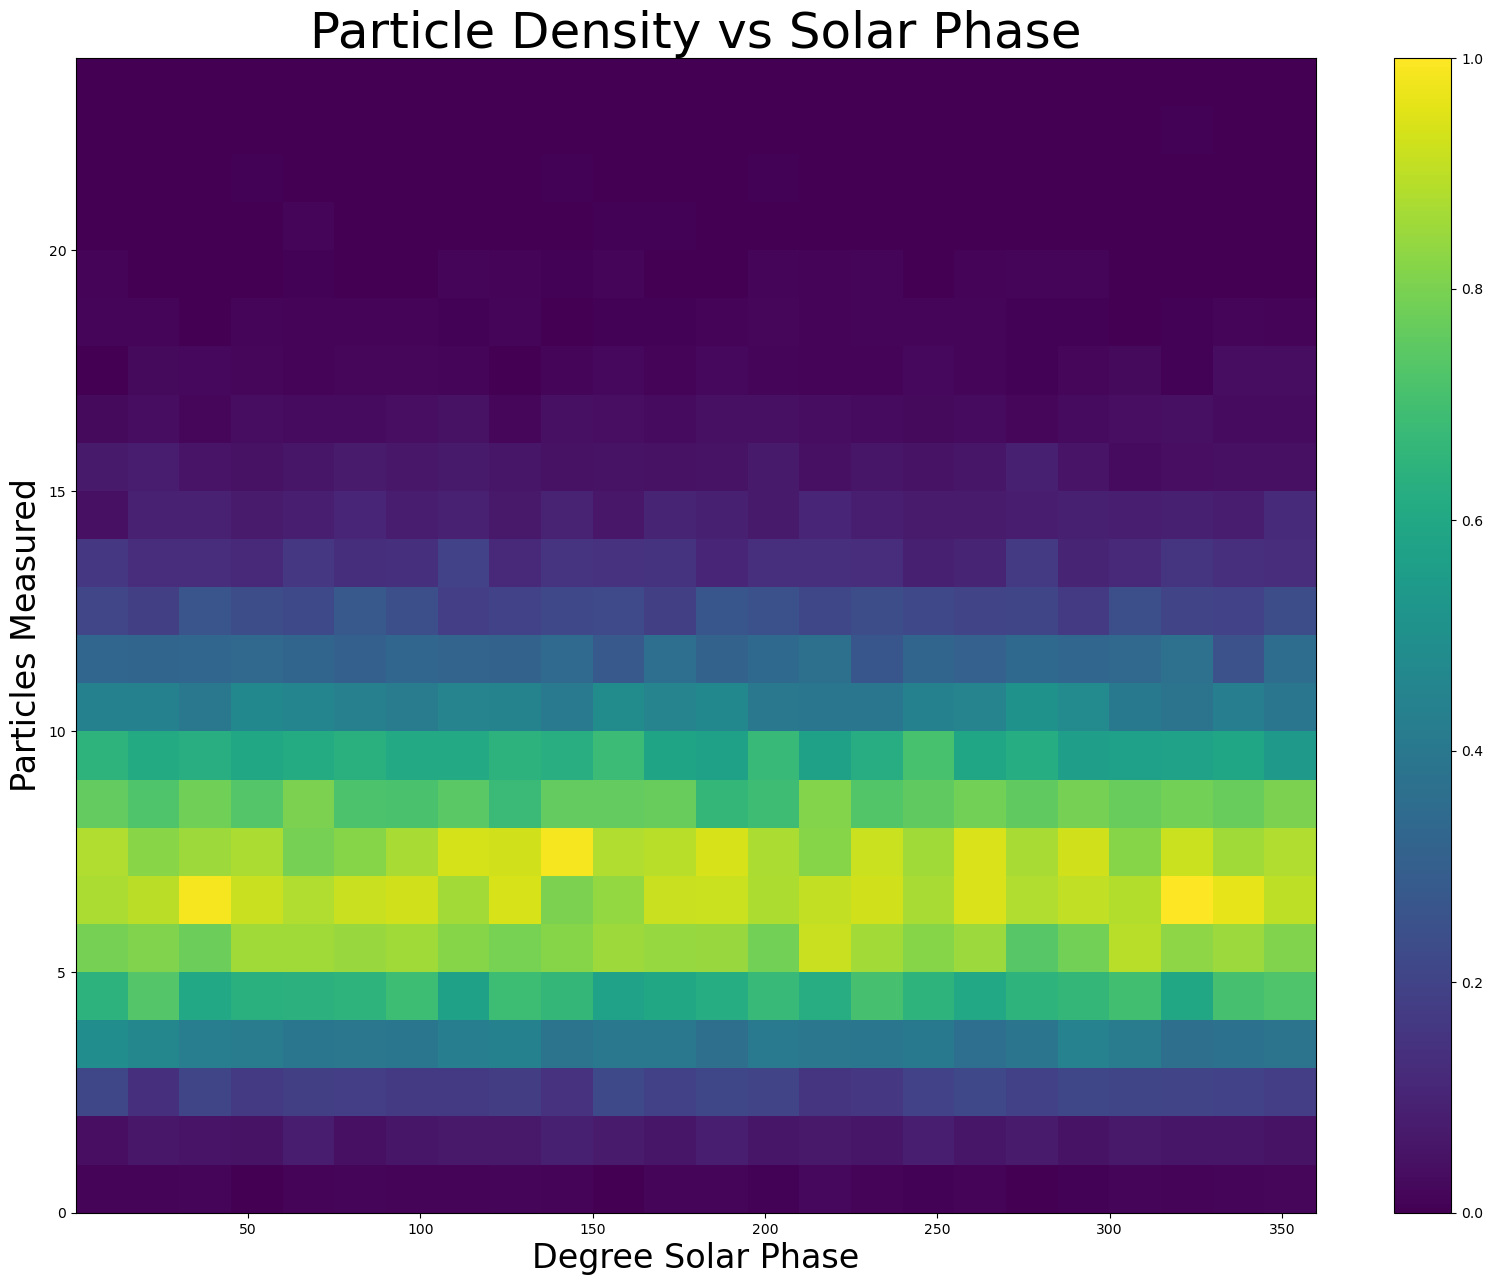

In [5]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.hist2d(df['solar_phase'][::500], df['count'][::500], bins = 24)
plt.xlabel("Degree Solar Phase", fontsize = 24)
plt.ylabel("Particles Measured", fontsize = 24)
plt.title("Particle Density vs Solar Phase", fontsize = 36)
plt.show()

We can see in the graph above the density of gamma ray measurement that there is very little to no dependance on the solar phase. At all points of solar phase, the density is relatively stable.

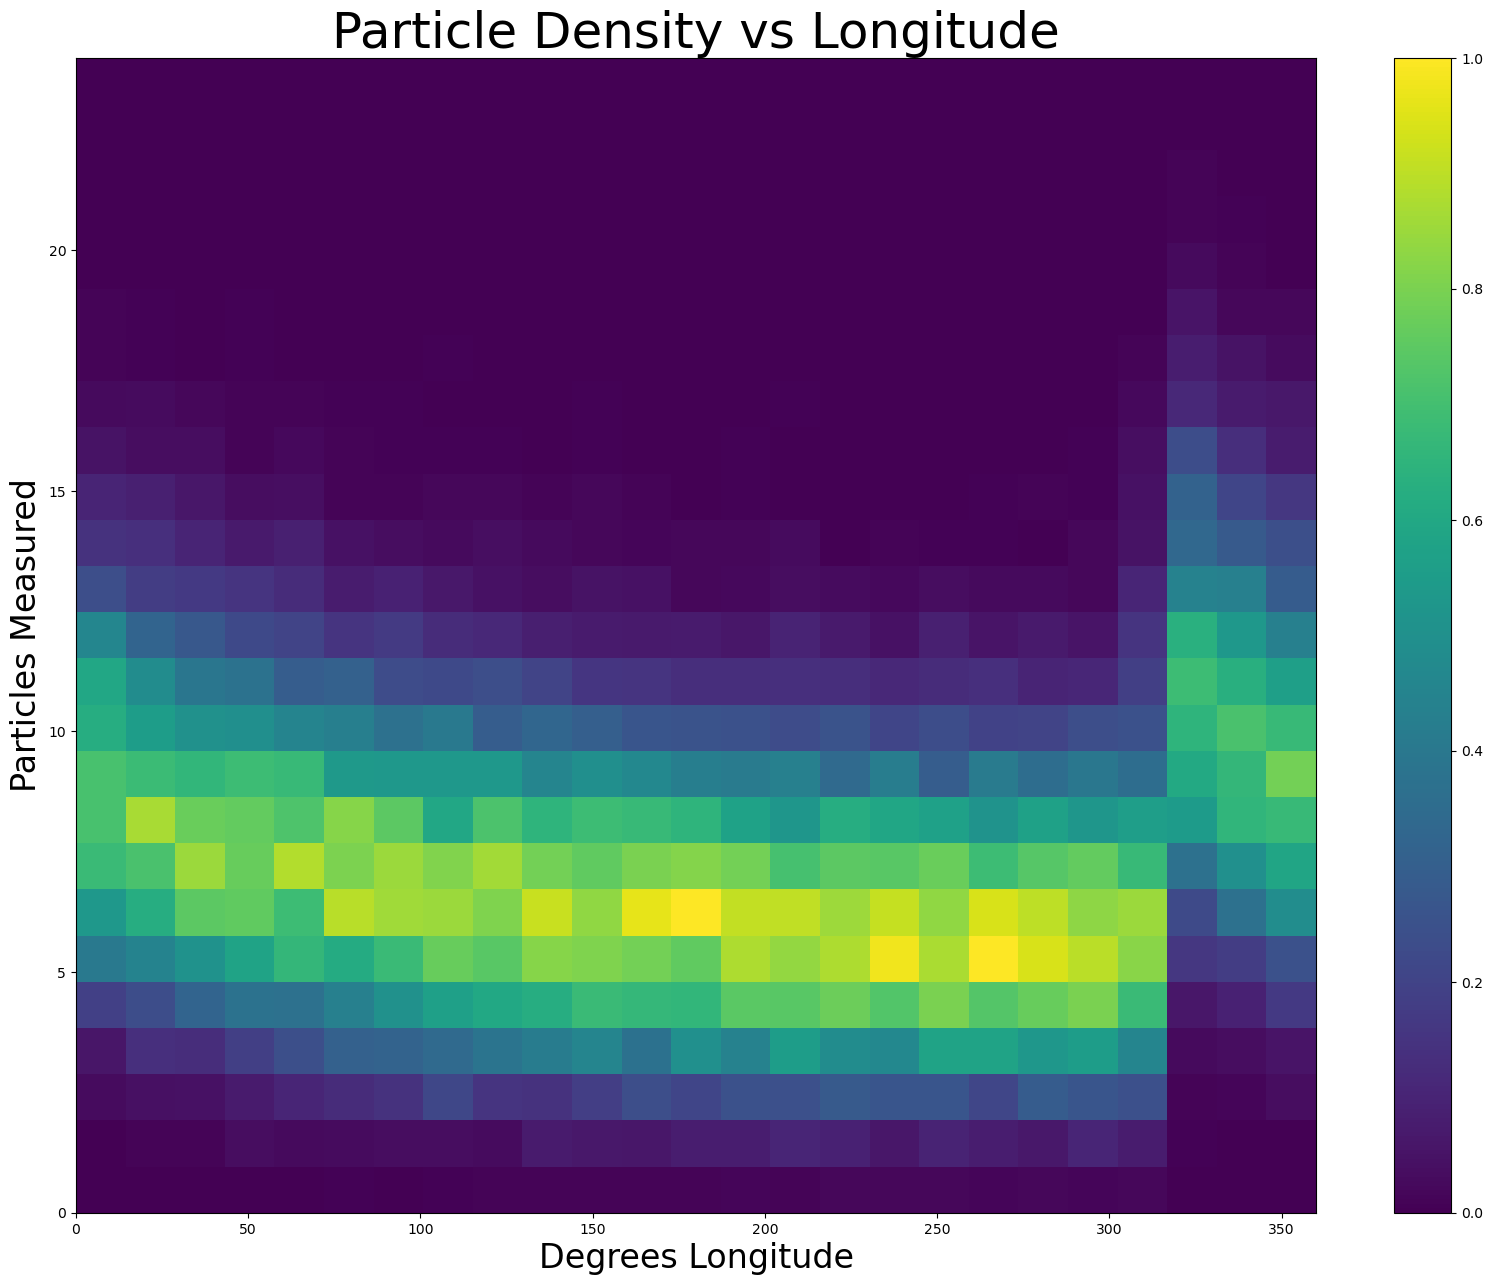

In [6]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.xlabel("Degrees Longitude", fontsize = 24)
plt.ylabel("Particles Measured", fontsize = 24)
plt.title("Particle Density vs Longitude", fontsize = 36)
plt.hist2d(df['longitude'][::502], df['count'][::502], bins = 25)
plt.show()

In [7]:
counts = [0]*360
for i in range(len(df["count"][::15])):
    counts[math.floor(df["longitude"][i*15])] += int(df["count"][i*15])
for i in range(len(counts)):
    counts[i] /= len(df["count"])/360

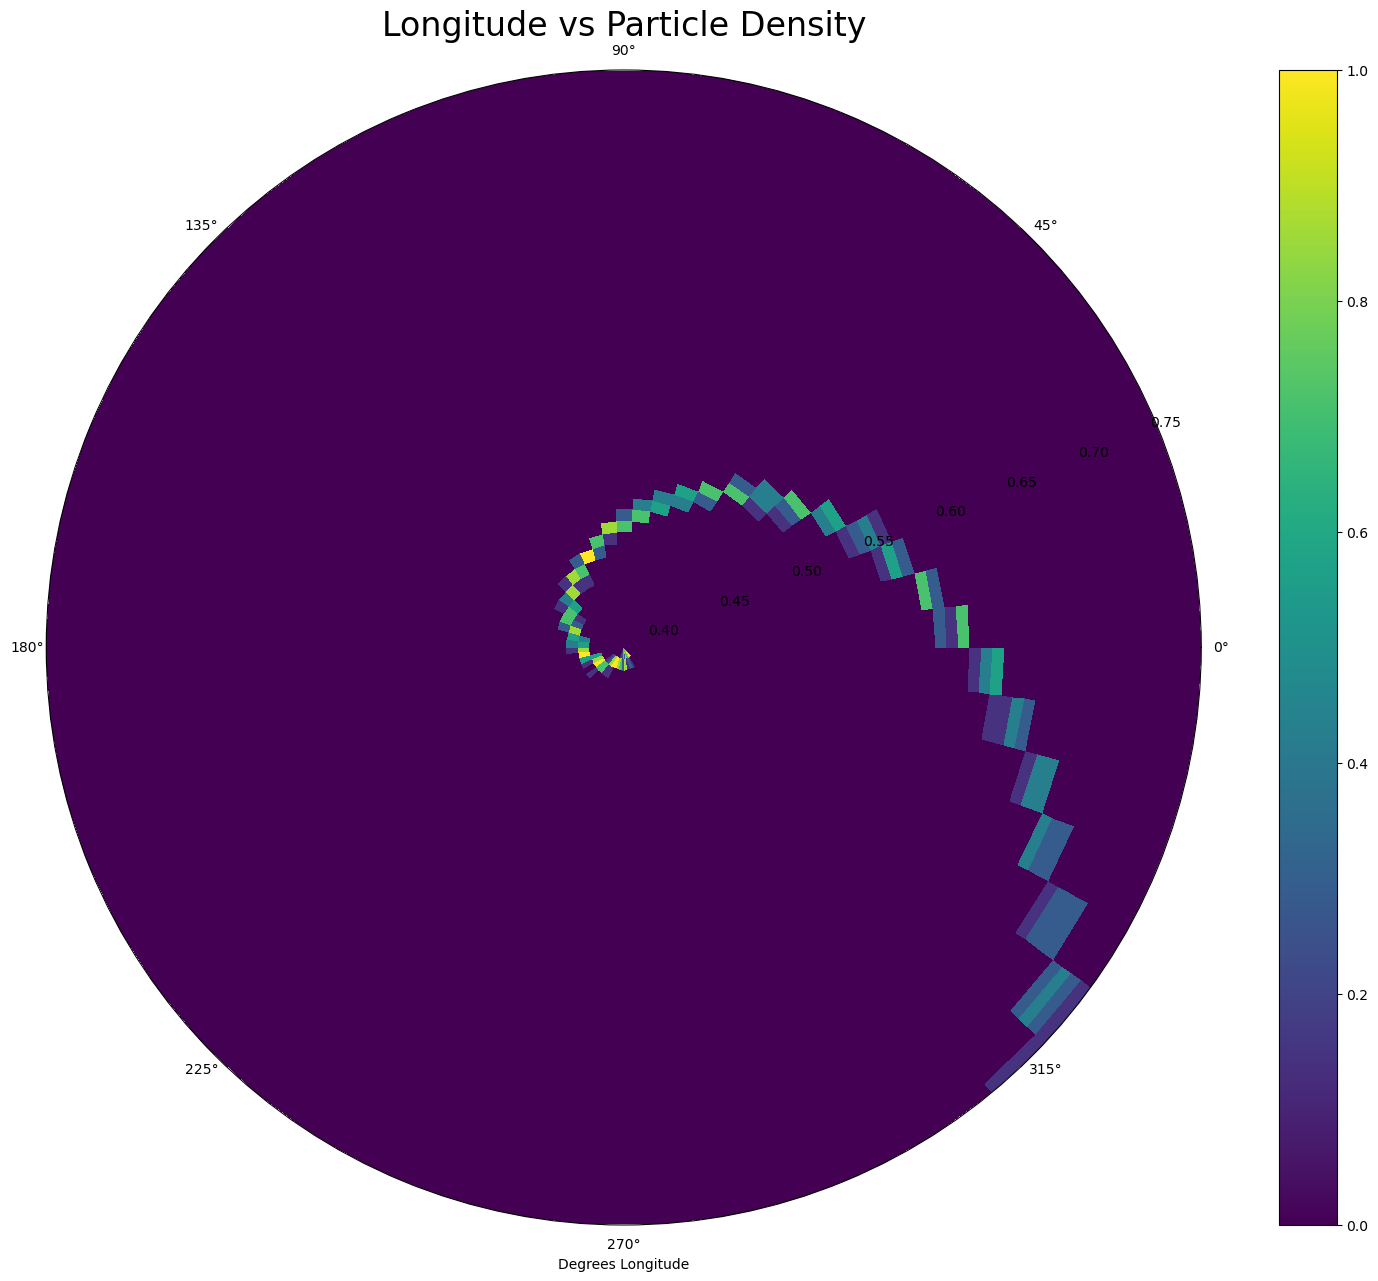

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.title("Longitude vs Particle Density", fontsize = 24)
plt.hist2d(np.linspace(0,2*np.pi,360), counts, bins = 50)
plt.xlabel("Degrees Longitude")
plt.show()

In the above two graphs we can see that the longitude has a significant impact on the distribution of the number of gama rays that we see. In the first graph, we see the mean of the distribution slowly decreases from 0 to 270, then sharply rises at 270, and continue to decrease till 360. The second graph shows the distribution as a polar 2D histogram, where a greater distance from the center is a higher measurement, and degree longitude corosponds directly with the degree around the circle. We begin to see a very interesting pattern appear here. We can actually see the mean grow in a spiral, showing the distribution grow as we go around the circle, then suddenly and sharply snap back to the start at a longitude of 270. From these two graphs, we can see that there is a clear relation between longitude and gamma rays that we count

# 3) Create a model for the background

In [9]:
means = [0]*54000
for i in range(54000):
    means[i] = df["count"][i::54000].mean()


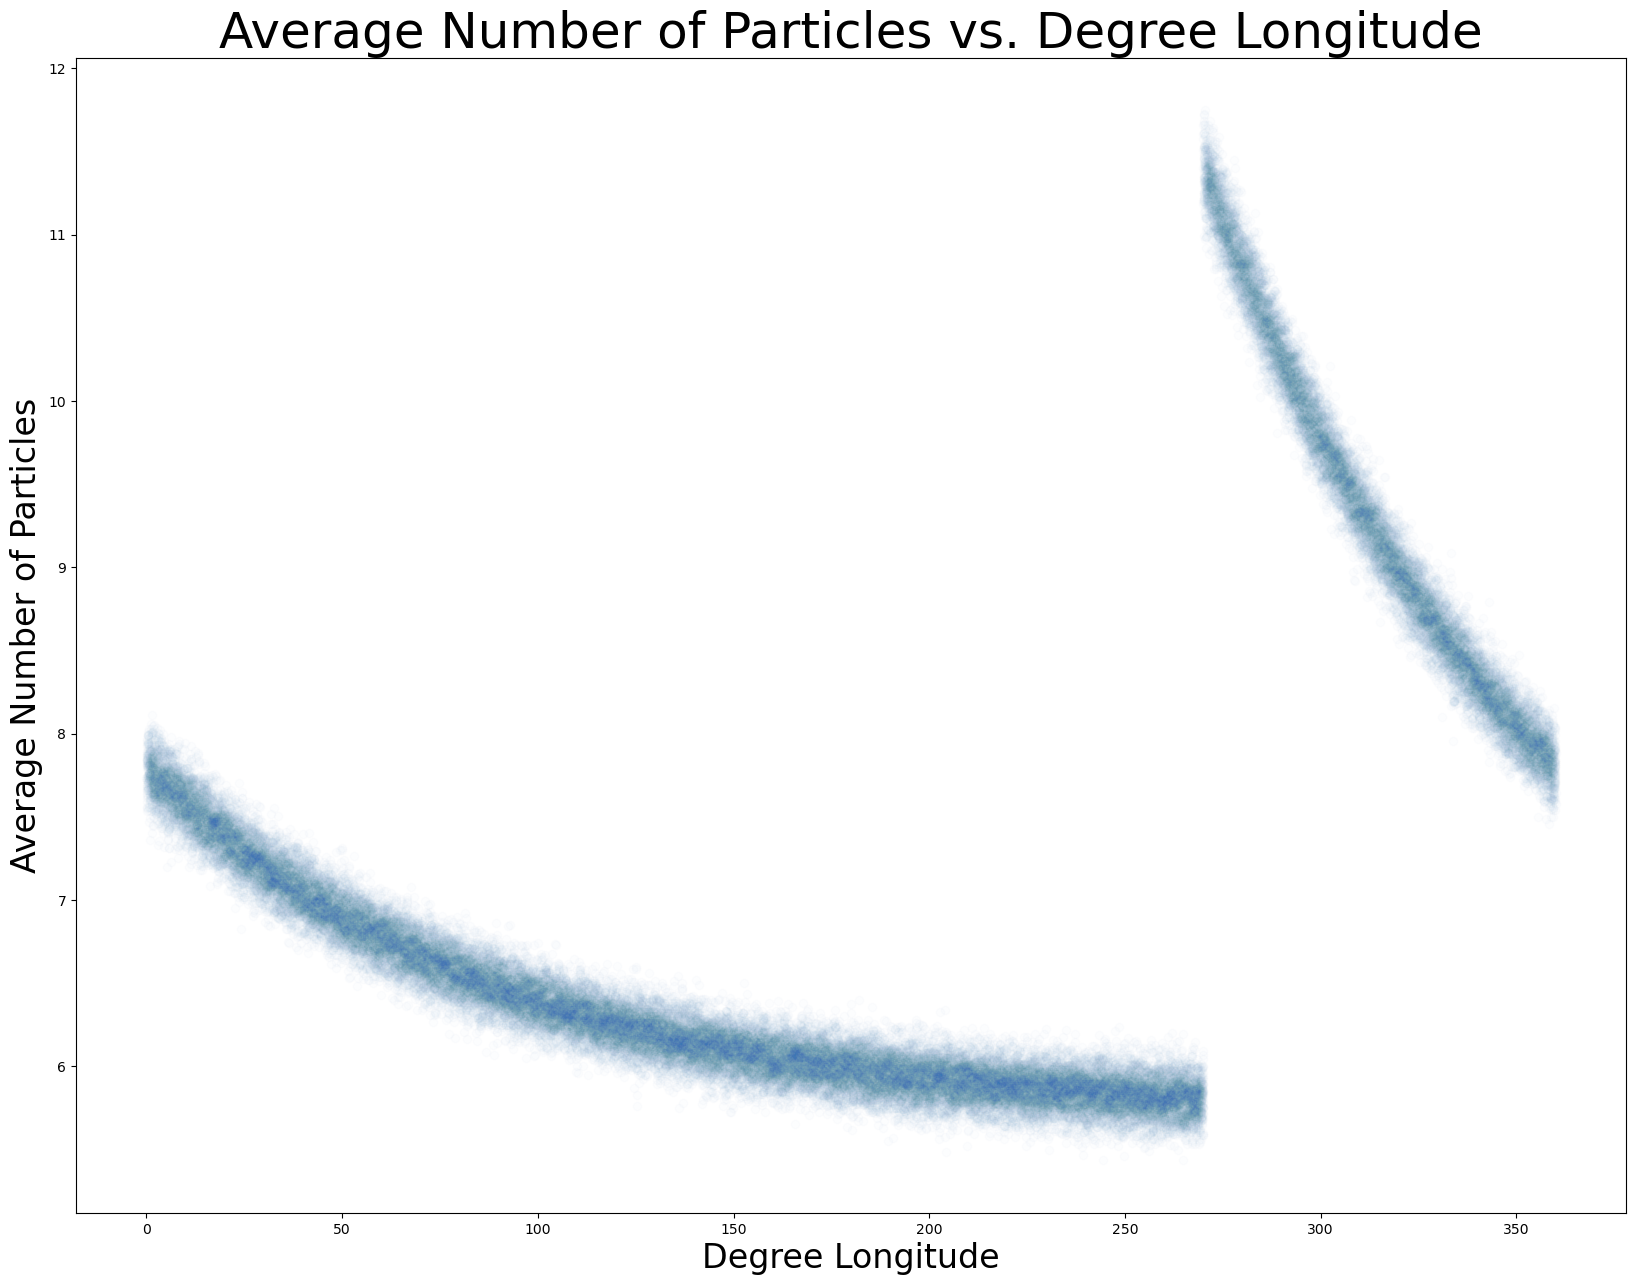

In [10]:
plt.scatter(x = np.linspace(0,360,54000),y = means, alpha = 0.01)
plt.xlabel("Degree Longitude", fontsize = 24)
plt.ylabel("Average Number of Particles", fontsize = 24)
plt.title("Average Number of Particles vs. Degree Longitude", fontsize = 36)
plt.show()

In [11]:
rearanged_means = means[40500:] + means[:40500]

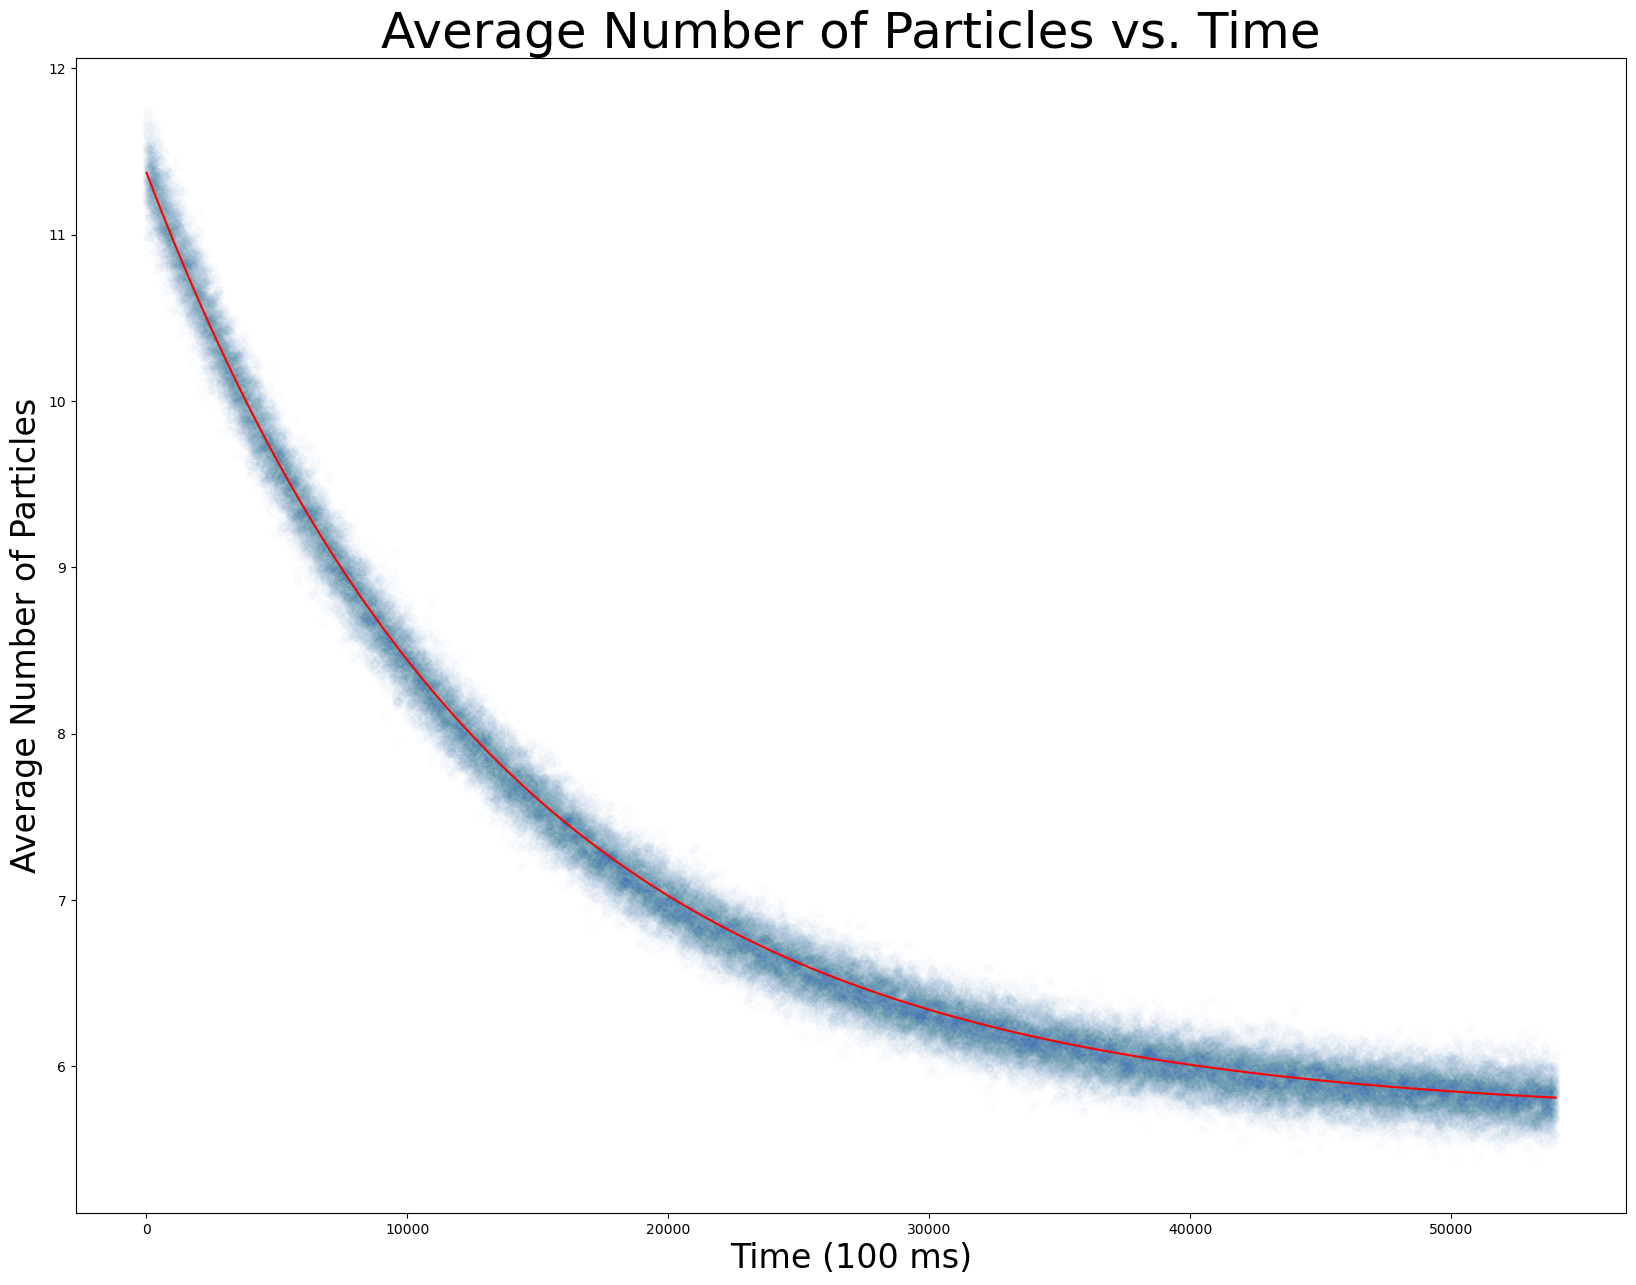

In [12]:
x = np.linspace(0,54000,54000)
y = scipy.stats.expon.pdf(x, scale = 13750)*78000+5.7
plt.scatter(x=x,y = rearanged_means, alpha = 0.01)
plt.plot(x, y, color = "red")
plt.xlabel("Time (100 ms)", fontsize = 24)
plt.ylabel("Average Number of Particles", fontsize = 24)
plt.title("Average Number of Particles vs. Time", fontsize = 36)
plt.show()

The above two graphs show the mean as a function of time. The first graph is starting at the start of the data set, and plotting the mean of every logitudinal point where data was taken, which are all isochronous. The second shows the same data, except shifted by 40500 measurements, and overlayed with an exponential curve. We can see that with some scaling adjustments to the curve, we find a nicely fitting overlay on the data. The equation for such a curve would be $f(t) = \frac{312}{55}e^{\frac{-t}{13750}}+5.57$, where $f(t)$ is number of expected gamma rays, and $t$ is time. This is a fairly accurate model of my data, and contains pretty much all the distribution within about $\pm 0.5$ gamma rays

## 4) 5-sigma threshold for a 100 millisecond GRB at different times

In [68]:
dist_per_time = [[-1]]*6
for i in range(6):
    measurements = [-1]*int((len(df["count"])-1)/54000)
    for j in range(math.floor((len(df["count"])-1)/54000)):
        measurements[j] = df["count"][54000*j + i*54000/6]
    dist_per_time[i] = measurements

The above code takes a selection of the data points, and makes a 2D array out of them. The outermost level of the array is the time, and the innermost is the measurement. The times selected were based on the satalites longitude.

In [69]:
means = [-1]*6
std = [-1]*6
for i in range(6):
    print("At a longitude of {} degrees, for a 5 sigma measurement, we need to see at least {} particles come through".format(
        df["longitude"][i*54000/6], (np.mean(dist_per_time[i]) + np.std(dist_per_time[i]) * 5)
    ))

At a longitude of 45.0 degrees, for a 5 sigma measurement, we need to see at least 21.000329562764158 particles come through
At a longitude of 105.0 degrees, for a 5 sigma measurement, we need to see at least 19.191318278294894 particles come through
At a longitude of 165.0 degrees, for a 5 sigma measurement, we need to see at least 18.106998931249105 particles come through
At a longitude of 225.0 degrees, for a 5 sigma measurement, we need to see at least 18.44609423006864 particles come through
At a longitude of 285.0 degrees, for a 5 sigma measurement, we need to see at least 17.18024874477308 particles come through
At a longitude of 345.0 degrees, for a 5 sigma measurement, we need to see at least 25.54554749152929 particles come through


In order to find a 5 sigma measurement, I calculated the mean of the data points for the distinct logitudes. Then I found the standard deviation of the data set. I multiplied the standard deviation by 5 and added the mean in order to find the minimum required value for a measurement of 5 sigma.

# Problem 2